['constant',
 'exchange_rate',
 'solar-energy',
 'electricity',
 'traffic',
 'exchange_rate_nips',
 'electricity_nips',
 'traffic_nips',
 'solar_nips',
 'wiki2000_nips',
 'wiki-rolling_nips',
 'taxi_30min',
 'kaggle_web_traffic_with_missing',
 'kaggle_web_traffic_without_missing',
 'kaggle_web_traffic_weekly',
 'm1_yearly',
 'm1_quarterly',
 'm1_monthly',
 'nn5_daily_with_missing',
 'nn5_daily_without_missing',
 'nn5_weekly',
 'tourism_monthly',
 'tourism_quarterly',
 'tourism_yearly',
 'cif_2016',
 'london_smart_meters_without_missing',
 'wind_farms_without_missing',
 'car_parts_without_missing',
 'dominick',
 'fred_md',
 'pedestrian_counts',
 'hospital',
 'covid_deaths',
 'kdd_cup_2018_without_missing',
 'weather',
 'm3_monthly',
 'm3_quarterly',
 'm3_yearly',
 'm3_other',
 'm4_hourly',
 'm4_daily',
 'm4_weekly',
 'm4_monthly',
 'm4_quarterly',
 'm4_yearly',
 'm5',
 'uber_tlc_daily',
 'uber_tlc_hourly',
 'airpassengers',
 'australian_electricity_demand',
 'electricity_hourly',
 'elec

/home/tonicardoso/anaconda3/envs/investigacao/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


(array([0.21998051, 0.04397812, 0.03804395, 0.04962798, 0.04260562]),
 array([0.21998051, 0.05082938, 0.05806494, 0.057676  , 0.05337962,
        0.06361728]))

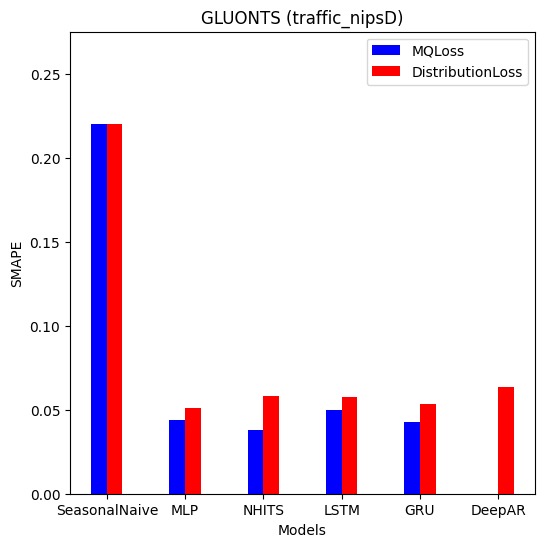

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from codebase.load_data.m3 import M3Dataset
from codebase.load_data.tourism import TourismDataset
from codebase.load_data.gluonts import GluontsDataset
from matplotlib.pyplot import close

def plot_smape(dataset_name, group):

    if group == 'traffic_nips':
        group += GluontsDataset.frequency_pd['traffic_nips']

    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("./results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("./results") :
        return

    MQL = pd.read_csv(f"./results/{dataset_name}_{group}_MQLoss/smape_{dataset_name}_{group}_MQLoss.csv")
    DL = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/smape_{dataset_name}_{group}_DistributionLoss.csv")

    MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in MQL.columns]
    DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in DL.columns]

    MQL_means = MQL.drop(columns='unique_id').mean()
    DL_means = DL.drop(columns='unique_id').mean()

    y_max = max(MQL_means.max(), DL_means.max())

    combined_means = pd.concat([MQL_means, DL_means], axis=1)
    combined_means.columns = ['MQL', 'DL']

    fig, ax = plt.subplots(figsize=(6, 6))

    bar_width = 0.2
    index = np.arange(len(combined_means))

    bar1 = ax.bar(index, combined_means['MQL'], bar_width, label='MQLoss', color='b')
    bar2 = ax.bar(index + bar_width, combined_means['DL'], bar_width, label='DistributionLoss', color='r')

    ax.set_xlabel('Models')
    ax.set_ylabel('SMAPE')
    ax.set_ylim(0, 1.25*y_max)
    ax.set_title(f'{dataset_name} ({group})')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(combined_means.index)
    ax.legend(loc='upper right')

    plt.savefig(f"plots/smape/smape_{dataset_name}_{group}.png")

    return MQL_means.values, DL_means.values

plot_smape("GLUONTS", "traffic_nips")

array([[0.89377469, 0.89377469,        nan],
       [0.9442997 , 0.94901607, 0.93037096],
       [0.94258154, 0.94764076, 0.93067706],
       [0.93885728, 0.94210347, 0.92344561],
       [0.94210786, 0.94710105, 0.9250146 ],
       [       nan, 0.90909188,        nan]])

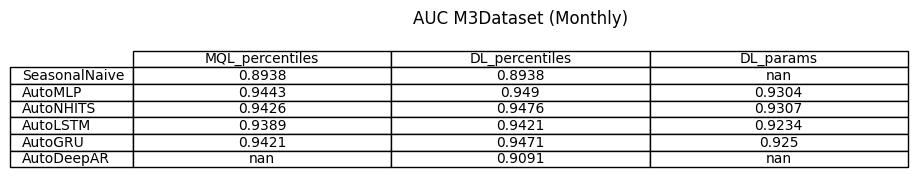

In [2]:
def plot_auc(dataset_name, group):
    
    if group == 'traffic_nips':
        group += GluontsDataset.frequency_pd['traffic_nips']

    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("./results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("./results"):
        return
    
    MQL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_MQLoss/auc_logloss_percentiles_{dataset_name}_{group}_MQLoss.csv")
    DL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset_name}_{group}_DistributionLoss.csv")
    DL_params = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_params_{dataset_name}_{group}_DistributionLoss.csv")

    matrix = {}
    for df_name, df in [('MQL_percentiles', MQL_percentiles), ("DL_percentiles", DL_percentiles), ("DL_params", DL_params)]:
        auc_means = {}
        for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        #for model in ['SeasonalNaive', 'MLP', 'NHITS', 'LSTM', 'GRU', 'DeepAR']:
            auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['AUC'].mean() 
            auc_means[model] = auc
        matrix[df_name] = auc_means

    auc_df = pd.DataFrame(matrix)

    fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
    plt.title(f'AUC {dataset_name} ({group})')
    plt.savefig(f"plots/auc/auc_{dataset_name}_{group}.png")

    return auc_df.values

plot_auc("M3Dataset", "Monthly")

array([[0.37905244, 0.37905244,        nan],
       [0.26756358, 0.25498192, 0.52334145],
       [0.26999005, 0.25907744, 0.52251466],
       [0.2781018 , 0.26865399, 0.5230386 ],
       [0.2686623 , 0.26334129, 0.52593263],
       [       nan, 0.39126534,        nan]])

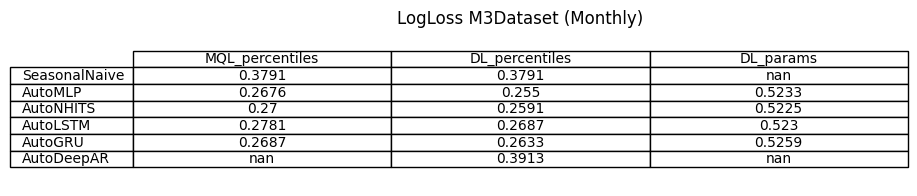

In [3]:
def plot_logloss(dataset_name, group):

    if group == 'traffic_nips':
        group += GluontsDataset.frequency_pd['traffic_nips']
    
    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("./results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("./results") :
        return
    
    MQL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_MQLoss/auc_logloss_percentiles_{dataset_name}_{group}_MQLoss.csv")
    DL_percentiles = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset_name}_{group}_DistributionLoss.csv")
    DL_params = pd.read_csv(f"./results/{dataset_name}_{group}_DistributionLoss/auc_logloss_params_{dataset_name}_{group}_DistributionLoss.csv")

    matrix = {}
    for df_name, df in [('MQL_percentiles', MQL_percentiles), ("DL_percentiles", DL_percentiles), ("DL_params", DL_params)]:
        logloss_means = {}
        for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        #for model in ['SeasonalNaive', 'MLP', 'NHITS', 'LSTM', 'GRU', 'DeepAR']:
            auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['LogLoss'].mean() 
            logloss_means[model] = auc
        matrix[df_name] = logloss_means

    logloss_df = pd.DataFrame(matrix)

    fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=logloss_df.round(4).values, colLabels=logloss_df.columns, rowLabels=logloss_df.index, cellLoc='center', loc='center')
    plt.title(f'LogLoss {dataset_name} ({group})')
    plt.savefig(f"plots/logloss/logloss_{dataset_name}_{group}.png")

    return logloss_df.values

plot_logloss("M3Dataset", "Monthly")

In [4]:
os.system("rm ./plots/smape/* ./plots/auc/* ./plots/logloss/*")

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():
        print(dataset._DATASET_NAME, group)
        plot_smape(dataset._DATASET_NAME, group); close()
        plot_auc(dataset._DATASET_NAME, group); close()
        plot_logloss(dataset._DATASET_NAME, group); close()

M3Dataset Monthly
Tourism Monthly
GLUONTS electricity_weekly
GLUONTS traffic_nips


/tmp/ipykernel_8796/239427900.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
/tmp/ipykernel_8796/239427900.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


,MQL,DL
SeasonalNaive,0.237257,0.237257
MLP,0.173804,0.176449
NHITS,0.172348,0.178574
LSTM,0.177203,0.180057
GRU,0.174725,0.179618
DeepAR,NaN,0.185434


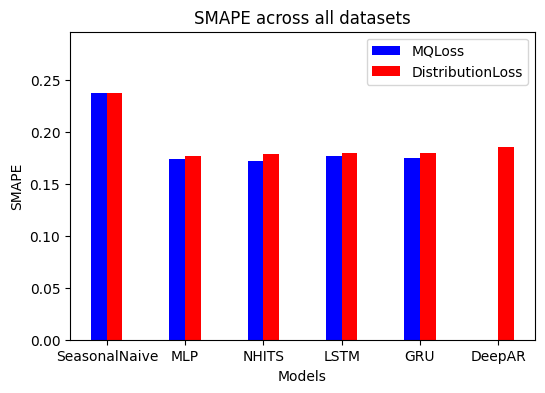

In [5]:
smape_global_MQL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU'])
smape_global_DL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU','DeepAR'])


for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']
        
        smape_MQL = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_MQLoss/smape_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        smape_DL = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/smape_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")

        smape_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_MQL.columns]
        smape_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_DL.columns]

        smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
        smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


smape_global_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_MQL.columns]
smape_global_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_DL.columns]

MQL_means = smape_global_MQL.drop(columns='unique_id').mean()
DL_means = smape_global_DL.drop(columns='unique_id').mean()

y_max = max(MQL_means.max(), DL_means.max())

combined_means = pd.concat([MQL_means, DL_means], axis=1)
combined_means.columns = ['MQL', 'DL']

fig, ax = plt.subplots(figsize=(6, 4))

bar_width = 0.2
index = np.arange(len(combined_means))

bar1 = ax.bar(index, combined_means['MQL'], bar_width, label='MQLoss', color='b')
bar2 = ax.bar(index + bar_width, combined_means['DL'], bar_width, label='DistributionLoss', color='r')

ax.set_xlabel('Models')
ax.set_ylabel('SMAPE')
ax.set_ylim(0, 1.25*y_max)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_means.index)
ax.legend(loc='upper right')
ax.set_title("SMAPE across all datasets")
plt.savefig("plots/smape_global_mean.png")

combined_means

/tmp/ipykernel_8796/4165919333.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
/tmp/ipykernel_8796/4165919333.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
/tmp/ipykernel_8796/4165919333.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futur

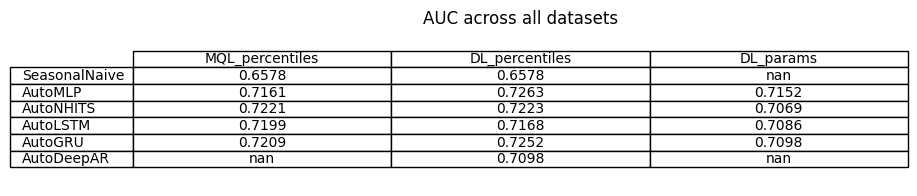

In [6]:
auc_global_MQL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_params = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']

        MQL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_MQLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        DL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        DL_params = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_params_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        
        if 'traffic_nips' in group:
            MQL_percentiles.drop([0, 5, 10], inplace=True)
            DL_percentiles.drop([0, 6, 12], inplace=True)

        auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
        auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
        auc_global_DL_params = pd.concat([auc_global_DL_params, DL_params], axis=0)

matrix = {}
for df_name, df in [('MQL_percentiles', auc_global_MQL_percentiles), ("DL_percentiles", auc_global_DL_percentiles), ("DL_params", auc_global_DL_params)]:
    auc_means = {}
    for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['AUC'].mean() 
        auc_means[model] = auc
    matrix[df_name] = auc_means

auc_df = pd.DataFrame(matrix)

fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
ax.axis('tight')
ax.axis('off')
ax.set_title("AUC across all datasets")

table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
plt.savefig("plots/auc_global_mean.png")

/tmp/ipykernel_8796/3277812028.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  logloss_global_MQL_percentiles = pd.concat([logloss_global_MQL_percentiles, MQL_percentiles], axis=0)
/tmp/ipykernel_8796/3277812028.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  logloss_global_DL_percentiles = pd.concat([logloss_global_DL_percentiles, DL_percentiles], axis=0)
/tmp/ipykernel_8796/3277812028.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprec

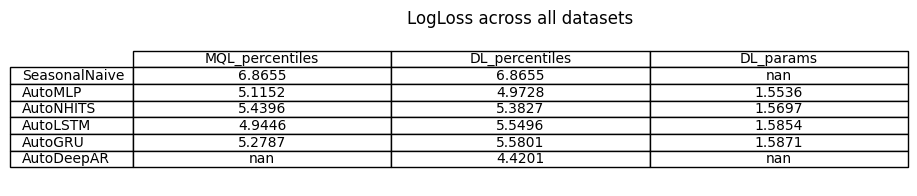

In [7]:
logloss_global_MQL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
logloss_global_DL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
logloss_global_DL_params = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']
            
        MQL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_MQLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        DL_percentiles = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        DL_params = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_params_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        
        if 'traffic_nips' in group:
            MQL_percentiles.drop([0, 5, 10], inplace=True)
            DL_percentiles.drop([0, 6, 12], inplace=True)

        logloss_global_MQL_percentiles = pd.concat([logloss_global_MQL_percentiles, MQL_percentiles], axis=0)
        logloss_global_DL_percentiles = pd.concat([logloss_global_DL_percentiles, DL_percentiles], axis=0)
        logloss_global_DL_params = pd.concat([logloss_global_DL_params, DL_params], axis=0)

matrix = {}
for df_name, df in [('MQL_percentiles', logloss_global_MQL_percentiles), ("DL_percentiles", logloss_global_DL_percentiles), ("DL_params", logloss_global_DL_params)]:
    logloss_means = {}
    for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['LogLoss'].mean() 
        logloss_means[model] = auc
    matrix[df_name] = logloss_means

logloss_df = pd.DataFrame(matrix)

fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
ax.axis('tight')
ax.axis('off')
ax.set_title("LogLoss across all datasets")

table = ax.table(cellText=logloss_df.round(4).values, colLabels=logloss_df.columns, rowLabels=logloss_df.index, cellLoc='center', loc='center')
plt.savefig("plots/logloss_global_mean.png")

In [8]:
from neuralforecast.losses.numpy import mqloss

mqloss_metric_df = {}

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']
        
        for loss_name in ['MQLoss', 'DistributionLoss']:
            experiment_id = f'{dataset._DATASET_NAME}_{group}_{loss_name}'
        
            forecast_df = pd.read_csv(f"./results/{experiment_id}/forecast_df_{experiment_id}.csv")
            models_names = ['SeasonalNaive', 'MLP', 'NHITS', 'LSTM', 'GRU']
            if loss_name == 'DistributionLoss':
                models_names.append('DeepAR')

            mqloss_metric_df[f'{experiment_id}'] = {}
            for model in models_names:

                df = forecast_df[filter(lambda col: model in col, forecast_df.columns)].drop(columns=[f'Auto{model}', f'Auto{model}-loc', f'Auto{model}-scale'], errors='ignore')
                mql = []
                for i in range(len(df)):
                    y =  np.array([forecast_df['y_true'][i]])
                    y_hat = df.iloc[i, :].to_numpy()
                    quantiles = np.array([0.5, 0.01, 0.05, 0.1, 0.9, 0.95, 0.99])
                    #print(y_hat)
                    mql.append(mqloss(y, y_hat, quantiles))
                mqloss_metric_df[f'{experiment_id}'][model.removeprefix("Auto")] = np.mean(mql)
            
pd.DataFrame(mqloss_metric_df)

,M3Dataset_Monthly_MQLoss,M3Dataset_Monthly_DistributionLoss,Tourism_Monthly_MQLoss,Tourism_Monthly_DistributionLoss,GLUONTS_electricity_weekly_MQLoss,GLUONTS_electricity_weekly_DistributionLoss,GLUONTS_traffic_nipsD_MQLoss,GLUONTS_traffic_nipsD_DistributionLoss
SeasonalNaive,157.850242,157.850242,14173.462289,14173.462289,346347.047059,346347.047059,0.011703,0.011703
MLP,113.915239,115.991920,13789.580829,13536.803670,339677.174907,340659.347644,0.001311,0.001452
NHITS,114.037394,114.976814,14130.837296,14078.037050,353115.698421,355819.298973,0.001258,0.001529
LSTM,118.254240,117.904698,13368.950968,13838.855881,337516.367952,349157.481876,0.001313,0.001554
GRU,113.808149,117.311167,13811.925263,14194.237435,341995.275833,338420.326725,0.001230,0.001437
DeepAR,NaN,135.867655,NaN,12574.383565,NaN,328826.950110,NaN,0.001582


In [9]:
dict_smape = {'model': [], 'experiment': [], 'SMAPE': []}
dict_mqloss = {'model': [], 'experiment': [], 'MQL': []}

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']
        
        for loss_name in ['MQLoss', 'DistributionLoss']:
            experiment_id = f'{dataset._DATASET_NAME}_{group}_{loss_name}'

            smape_df = pd.read_csv(f"./results/{experiment_id}/smape_{experiment_id}.csv")
            smape_df.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_df.columns]
            smape_df = smape_df.drop(columns='unique_id').mean()
            
            forecast_df = pd.read_csv(f"./results/{experiment_id}/forecast_df_{experiment_id}.csv")

            models_names = ['SeasonalNaive', 'MLP', 'NHITS', 'LSTM', 'GRU']
            if loss_name == 'DistributionLoss':
                models_names.append('DeepAR')

            for model_name in models_names:
                dict_smape['model'].append(model_name)
                dict_smape['experiment'].append(experiment_id)
                dict_smape['SMAPE'].append(smape_df[model_name])

                df = forecast_df[filter(lambda col: model_name in col, forecast_df.columns)].drop(columns=[f'Auto{model_name}', f'Auto{model_name}-loc', f'Auto{model_name}-scale'], errors='ignore')
                mql = []
                for i in range(len(df)):
                    y =  np.array([forecast_df['y_true'][i]])
                    y_hat = df.iloc[i, :].to_numpy()
                    quantiles = np.array([0.5, 0.01, 0.05, 0.1, 0.9, 0.95, 0.99])
                    mql.append(mqloss(y, y_hat, quantiles))
                
                dict_mqloss['model'].append(model_name)
                dict_mqloss['experiment'].append(experiment_id)
                dict_mqloss['MQL'].append(np.mean(mql))

In [10]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

df_smape = pd.DataFrame(dict_smape)
df_mqloss = pd.DataFrame(dict_mqloss)

merged_df = pd.merge(df_smape, df_mqloss, on=['model', 'experiment'])

# Calculate Pearson correlation for raw metrics
pearson_corr, _ = pearsonr(merged_df['SMAPE'], merged_df['MQL'])

# Calculate Spearman correlation for raw metrics
spearman_corr, _ = spearmanr(merged_df['SMAPE'], merged_df['MQL'])

# Rank the models within each dataset based on SMAPE and Multi-Quantile Loss
merged_df['SMAPE_rank'] = merged_df.groupby('experiment')['SMAPE'].rank(ascending=True)
merged_df['MQL_rank'] = merged_df.groupby('experiment')['MQL'].rank(ascending=True)

# Calculate Spearman correlation based on the rankings
spearman_rank_corr, _ = spearmanr(merged_df['SMAPE_rank'], merged_df['MQL_rank'])

print("Pearson correlation:", pearson_corr)
print("Spearman correlation:", spearman_corr)
print("Spearman rank correlation:", spearman_rank_corr)


Pearson correlation: 0.4770211481904596
Spearman correlation: 0.7682221908924289
Spearman rank correlation: 0.6151162790697674


In [11]:
df_mqloss['rank'] = df_mqloss.groupby('experiment')['MQL'].rank(ascending=True)
avg_rank = df_mqloss.groupby('model')['rank'].mean().reset_index()
avg_rank_dict = dict(tuple(info) for info in reversed(avg_rank.values))

avg_rank_dict
avg_rank_dict = {
    'SeasonalNaive': avg_rank_dict['SeasonalNaive'],
    'MLP': avg_rank_dict['MLP'],
    'NHITS': avg_rank_dict['NHITS'],
    'LSTM': avg_rank_dict['LSTM'],
    'GRU': avg_rank_dict['GRU'],
    'DeepAR': avg_rank_dict['DeepAR']
}
avg_rank_dict

{'SeasonalNaive': 5.0,
 'MLP': 2.25,
 'NHITS': 3.5,
 'LSTM': 3.25,
 'GRU': 2.5,
 'DeepAR': 3.0}

/tmp/ipykernel_8796/1700359302.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
/tmp/ipykernel_8796/1700359302.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


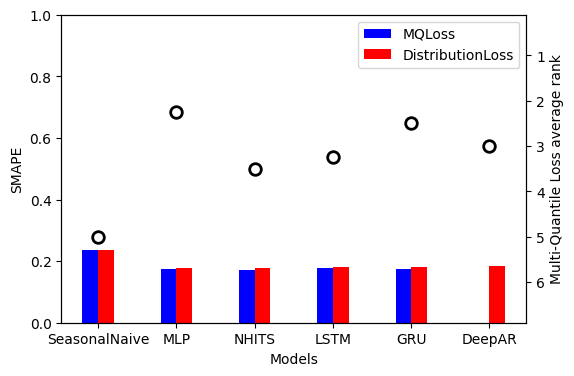

In [12]:
smape_global_MQL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU'])
smape_global_DL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU','DeepAR'])


for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():

        if group == 'traffic_nips':
            group += GluontsDataset.frequency_pd['traffic_nips']
        
        smape_MQL = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_MQLoss/smape_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        smape_DL = pd.read_csv(f"./results/{dataset._DATASET_NAME}_{group}_DistributionLoss/smape_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")

        smape_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_MQL.columns]
        smape_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_DL.columns]

        smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
        smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


smape_global_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_MQL.columns]
smape_global_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_DL.columns]

MQL_means = smape_global_MQL.drop(columns='unique_id').mean()
DL_means = smape_global_DL.drop(columns='unique_id').mean()

y_max = max(MQL_means.max(), DL_means.max())

combined_means = pd.concat([MQL_means, DL_means], axis=1)
combined_means.columns = ['MQL', 'DL']

fig, ax = plt.subplots(figsize=(6, 4))

bar_width = 0.2
index = np.arange(len(combined_means))

bar1 = ax.bar(index - bar_width / 2, combined_means['MQL'], bar_width, label='MQLoss', color='b')
bar2 = ax.bar(index + bar_width / 2, combined_means['DL'], bar_width, label='DistributionLoss', color='r')

ax.set_xlabel('Models')
ax.set_ylabel('SMAPE')
ax.set_ylim(0, 1)
ax.set_xticks(index)
ax.set_xticklabels(combined_means.index)
ax.legend(loc='upper right')
#ax.set_title("SMAPE and Multi-Quantile Loss average rank")


ax2 = ax.twinx()
ax2.set_ylim(0.1, 6.9)
ax2.set_ylabel('Multi-Quantile Loss average rank')
ax2.invert_yaxis()

plt.scatter(x=avg_rank_dict.keys(), y=avg_rank_dict.values(), color='white', edgecolor='black', s=70, linewidths=2, label='Average mqloss-metric rank')
plt.savefig("plots/smape_global_mean.png")
